# <center>Estimating mean profiles and fluxes in high-speed turbulent boundary layers using inner/outer-layer transformations</center>

             Created on: July 6, 2023
                Authors: Rene Pecnik (r.pecnik@tudelft.nl)
                         Asif M. Hasan (a.m.hasan@tudelft.nl)
                         Process & Energy Department, Faculty of 3mE
                         Delft University of Technology, the Netherlands.

       Last modified on: July 9, 2023 (Rene Pecnik) 


The following python code in this notebook is based on the publication: https://doi.org/10.48550/arXiv.2307.02199.



# Required functions 

### 1. Mean velocity (in non-dimensional form)
The mean velocity is obtained by 

$$ \bar u^+ = 
\int_{0}^{\delta^+} 
\left[\vphantom{\frac{1}{2}}\right.
\underbrace{\frac{\mu_w}{\bar \mu + \mu_t}}_{\text{Law of the wall}}
+  
\underbrace{\frac{\sqrt{\rho_w/\bar\rho}}{Re_\tau} \, \frac{\Pi}{\kappa} \, \pi\, \sin \left(\pi \frac{y}{\delta}\right)}_{\text{Law of the wake}}
\left.\vphantom{\frac{1}{2}}\right]
dy^+, $$

with the Johnson-King eddy eddy viscosity model, defined as 

$$\mu_t = \kappa \bar\mu y^* D(M_\tau), $$

and the modified van Driest damping function

$$ D(M_{\tau}) = \left[1 - \mathrm{exp}\left({\frac{-y^*}{A^+ + f(M_\tau)}}\right)\right]^2. $$

The constants and the function to account for intrinsic compressiblity effects in $D$ are given as

$$A^+ = 17,~\kappa=0.41,~\text{and}~f(M_\tau)=19.3M_\tau,~\text{where}~M_\tau=u_{\tau,w}/a_w .$$

The wake parameter is obtained by 

$${\Pi} = 0.69\,\left[1 - \exp(-0.243 \sqrt{z} - {0.15} \,z)\right],$$
with
$$z = Re_\theta/425 - 1.$$

In [1]:
def meanVelocity(ReTheta, ReTau, MTau, y_ye, r_rw, mu_muw):
    
    # Semi local Reynolds number and scaled wall distances 
    ReTauSt = ReTau*np.sqrt(r_rw)/mu_muw
    ypl     = y_ye*ReTau
    yst     = y_ye*ReTauSt
    
    # eddy viscosity model
    D   = (1-np.exp(-yst/(Apl + 19.3*MTau)))**2
    mut = kappa*mu_muw*yst*D
    
    # wake parameter
    z1   = ReTheta/425-1
    Pi   = 0.69*(1 - np.exp(-0.243*z1**0.5 - 0.150*z1))
    Wake = Pi/kappa*np.pi*np.sin(np.pi*y_ye)
    
    # velocity 
    upl  = cumtrapz(1/(mu_muw + mut) + 1/ReTau/np.sqrt(r_rw)*Wake, ypl, initial=0)
    
    upl_inf = upl[-1]/0.99 # calculate upl_inf

    return ypl, yst, upl, upl_inf

### 2. Temperature velocity relationship (Zhang et al. (2014), JFM)

$$\frac{\bar T}{T_w} =1+\frac{T_r-T_w}{T_w} \left[(1-sPr)\left(\frac{\bar u}{u_\infty}\right)^2+s \, {Pr}\left(\frac{\bar u}{u_\infty}\right)\right]+\frac{T_\infty-T_r}{T_w}\left(\frac{\bar u}{u_\infty}\right)^2,$$

where 
$$T_r/T_\infty = 1 + r \frac{(\gamma-1)}{2}M_\infty^2,$$

and
$$r=Pr^{1/3},~sPr=0.8,~\text{and}~Pr=0.72.$$


In [2]:
def temperature(u_uinf, Minf, Tw_Tr):
    
    r       = Pr**(1/3)
    Tr_Tinf = 1 + r*(gamma - 1)/2*Minf**2
    Tinf_Tw = 1/(Tw_Tr*Tr_Tinf)
    
    sPr  = 0.8
    T_Tw = 1 + (1/Tw_Tr-1)*u_uinf*((1-sPr)*(u_uinf) + sPr) + (Tinf_Tw-1/Tw_Tr)*(u_uinf)**2

    dTduinf_wall = (1/Tw_Tr - 1)*sPr # Derivate of T with respect to u. 
                                     # Used for calculation of heat transfer coefficient ch
    
    return T_Tw, Tinf_Tw, dTduinf_wall

### 3. Density profile (using ideal gas equation of state)

$$\frac{\bar\rho}{\rho_w} = \frac{1}{\overline T/T_w}$$


In [3]:
def density(T_Tw):
    return 1/T_Tw

### 4. Viscosity profile (using Sutherland's law)
$$\frac{\bar\mu}{\mu_w}=\left(\frac{\bar T}{T_w}\right)^{3 / 2} \frac{T_w+S}{\bar T+S},$$

where S = 110.56 K

In [4]:
def viscosity(T_Tw, Tinf_dim, Tinf_Tw, viscLaw):

    if viscLaw == "Sutherland":
        S     = 110.56/Tinf_dim * Tinf_Tw
        mu_muw= T_Tw**(1.5)*(1 + S)/(T_Tw + S)

    elif viscLaw == "PowerLaw":
        mu_muw = T_Tw**0.75

    else:
        print('Viscosity law ', viscLaw, " not available")
    
    return mu_muw

### 5. Computing $Re_\tau$ and $M_\tau$ using the inputs $Re_\theta$ and $M_\infty$
$$Re_\tau = {Re_\theta}\frac{ \mu_\infty/\mu_w}{(\rho_\infty/\rho_w) u_\infty^+ (\theta/\delta)}$$

$$M_\tau = M_\infty \sqrt{\frac{c_f}{2}}$$

In [5]:
def calcParameters(ReTheta, Minf, y_ye, r_rw, mu_muw, upl, uinf, 
                   T_Tw, Tw_Tr, Tinf_Tw, Tinf_dim, dTduinf_wall, viscLaw):
    
    rinf  = density(Tinf_Tw)
    muinf = viscosity(Tinf_Tw, Tinf_dim, Tinf_Tw, viscLaw)    

    Theta         = trapz(r_rw/rinf*upl/uinf*(1 - upl/uinf), y_ye)
    ReTheta_ReTau = rinf*uinf*Theta/muinf
    ReTau         = ReTheta/ReTheta_ReTau
    cf            = 2/(rinf*uinf**2)
    MTau          = Minf*(cf/2)**0.5    

    ch = np.nan     # ch=nan for adiabatic boundary layers
    if Tw_Tr != 1:
        # Calculate temperature gradeitn: dT/dy = dT/du * du+/dy+.
        # Since solver is based on viscous scales: du+/dy+ = 1
        dTdy_Wall = dTduinf_wall / uinf
        ch        = 1/Pr*dTdy_Wall/(rinf*uinf*(1/Tw_Tr - 1))   
    
    return ReTau, MTau, cf, ch

# Iterative solver

Required inputs are $Re_\theta$, $M_\infty$, $T_w/T_r$ and (optionally) the dimensional wall or free-stream temperature for Sutherland's law.  It is important to note that all solver inputs are based on the quantities in the free-stream, and not at the boundary layer edge.

In [6]:
# in case the notebook is executed on binder make sure that modules are installed.
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install pandas

In [7]:
import numpy as np
from scipy.integrate import cumtrapz, trapz

In [8]:
# n    ... number of points
# fact ... stretching/clustering
def grid(nPoints = 100, stretch = 5):
    H = 1.0       # --> y/y_e = 1
    tanhyp = 0.5  # half hyp tangens
    i = tanhyp*(np.arange(0,nPoints))/(nPoints-1) - 0.5
    y = 1./tanhyp*H * (1.0 + np.tanh(stretch*i)/np.tanh(stretch/2))/2.0
    return y

In [9]:
def solver(y_ye    = grid(200, 4), 
           ReTheta = 1000, Minf = 1.0, Tw_Tr = 1.0,    
           viscLaw = "Sutherland", Tinf_dim = 300):
    
    # set initial values for ReTau, MTau and upl
    ReTau = 100
    MTau  = 0.0
    upl   = np.ones_like(y_ye)*0.01
    uinf  = upl[-1]/0.99

    niter = 0
    err   = 1e10
    
    while(err > 1e-10 and niter < 1000):

        ReTauOld = ReTau
        
        T_Tw, Tinf_Tw, dTdu_inf = temperature(upl/uinf, Minf, Tw_Tr)
        mu_muw              = viscosity(T_Tw, Tinf_dim,Tinf_Tw, viscLaw)
        r_rw                = density(T_Tw)
        ypl, yst, upl, uinf = meanVelocity(ReTheta, ReTau, MTau, y_ye, r_rw, mu_muw)
        
        ReTau, MTau, cf, ch = calcParameters(ReTheta, Minf, y_ye, r_rw, mu_muw, upl, uinf, 
                                             T_Tw, Tw_Tr, Tinf_Tw, Tinf_dim, dTdu_inf, viscLaw)

        err = abs(ReTauOld-ReTau)
        niter += 1

    return cf, ch, ReTau, MTau, ypl, yst, upl, T_Tw, niter

### Import plotting modules

In [10]:
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rc('text', usetex=False)  # switch to True for latex font (might be slow)
rcParams.update({'font.size': 16})

# An example with $M_\infty=15$, $Re_\theta =10^7$, $T_w/T_r= 0.01$, and $T_\infty=100$ K

Convergence reached after 290 iterations.

Skin friction coefficient cf = 1.52722e-04 
Heat transfer coefficient ch = 8.48456e-05
ReTau = 2.03537e+07 
Mtau  = 1.31077e-01


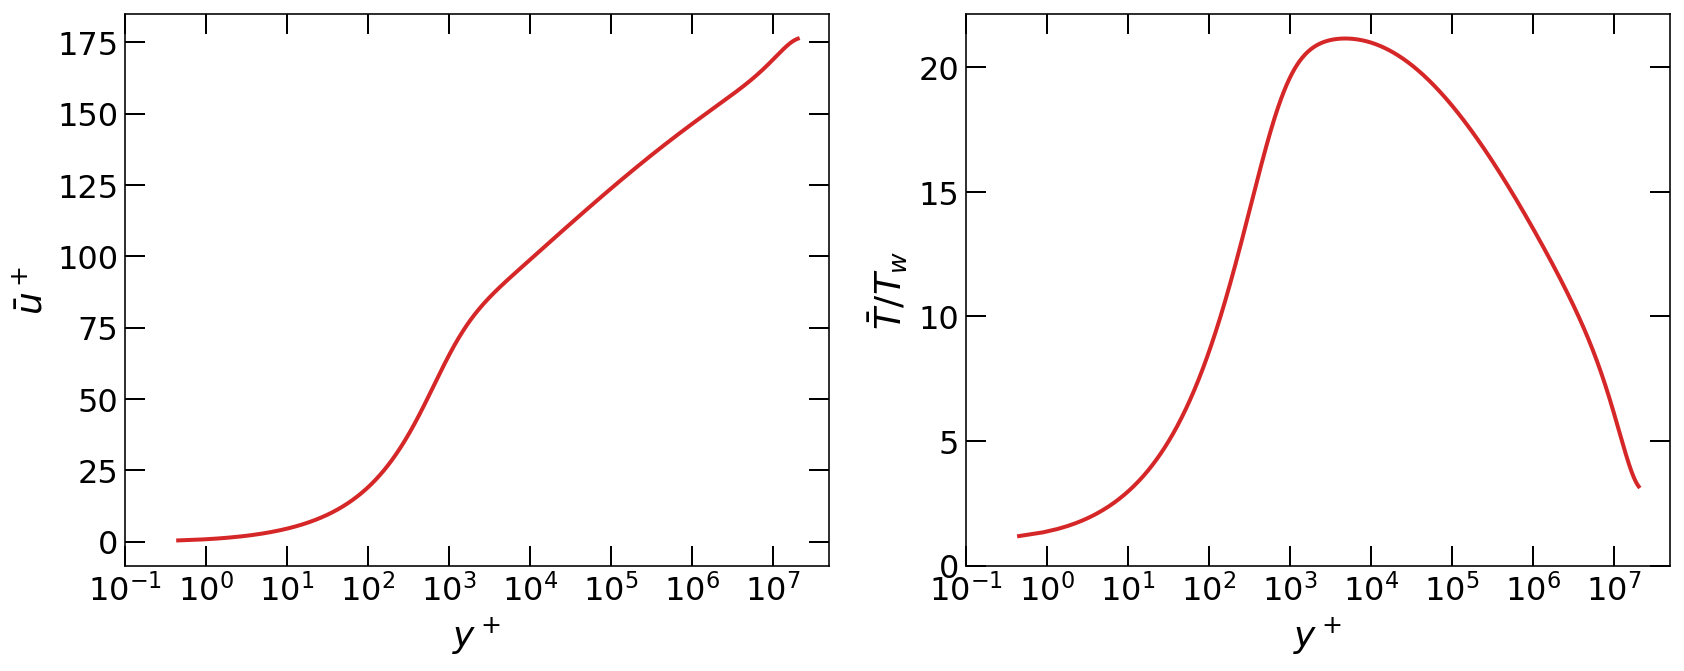

In [11]:
########################################
# Constants
#
gamma     = 1.4    # ratio of specific heat capacities
Pr        = 0.72   # Prandtl number
kappa     = 0.41   # Karman constant 
Apl       = 17     # Van Driest damping constant 

########################################
# Run a test case
#
cf,ch,ReTau,MTau,ypl,yst,upl,T,niter = solver(y_ye     = grid(100000, 9),
                                              ReTheta  = 1.0e7, 
                                              Minf     = 15.0, 
                                              Tw_Tr    = 0.01,
                                              viscLaw  = "Sutherland", 
                                              Tinf_dim = 100.0)

print('Convergence reached after {0} iterations.'.format(niter))
print('\nSkin friction coefficient cf = {0:.5e} \nHeat transfer coefficient ch = {1:.5e}'.format(cf, ch))
print('ReTau = {0:.5e} \nMtau  = {1:.5e}'.format(ReTau,MTau))

################################################
# plot profiles
#
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].semilogx(ypl[1:],upl[1:], color='tab:red', lw=2)
ax[1].semilogx(ypl[1:],T[1:],   color='tab:red', lw=2)
ax[0].set_ylabel(r"$\bar u^+$",  fontsize = 18)
ax[1].set_ylabel(r"$\bar T/T_w$",fontsize = 18)
for a in ax:
    a.tick_params(axis='both', which='both', direction='in',labelsize=16,right=True,top=True)
    a.tick_params(which='major', length=10, width=1)
    a.tick_params(which='minor', length=5,  width=1)
    a.set_xticks(10.0**np.arange(-1, 8, 1))
    a.set_xlabel(r"$y^+$",fontsize = 18)
ax[1].set_yticks(np.arange(0,25,5))
plt.tight_layout()

# Compare $c_f$ and $c_h$ estimates with various DNS cases from literature

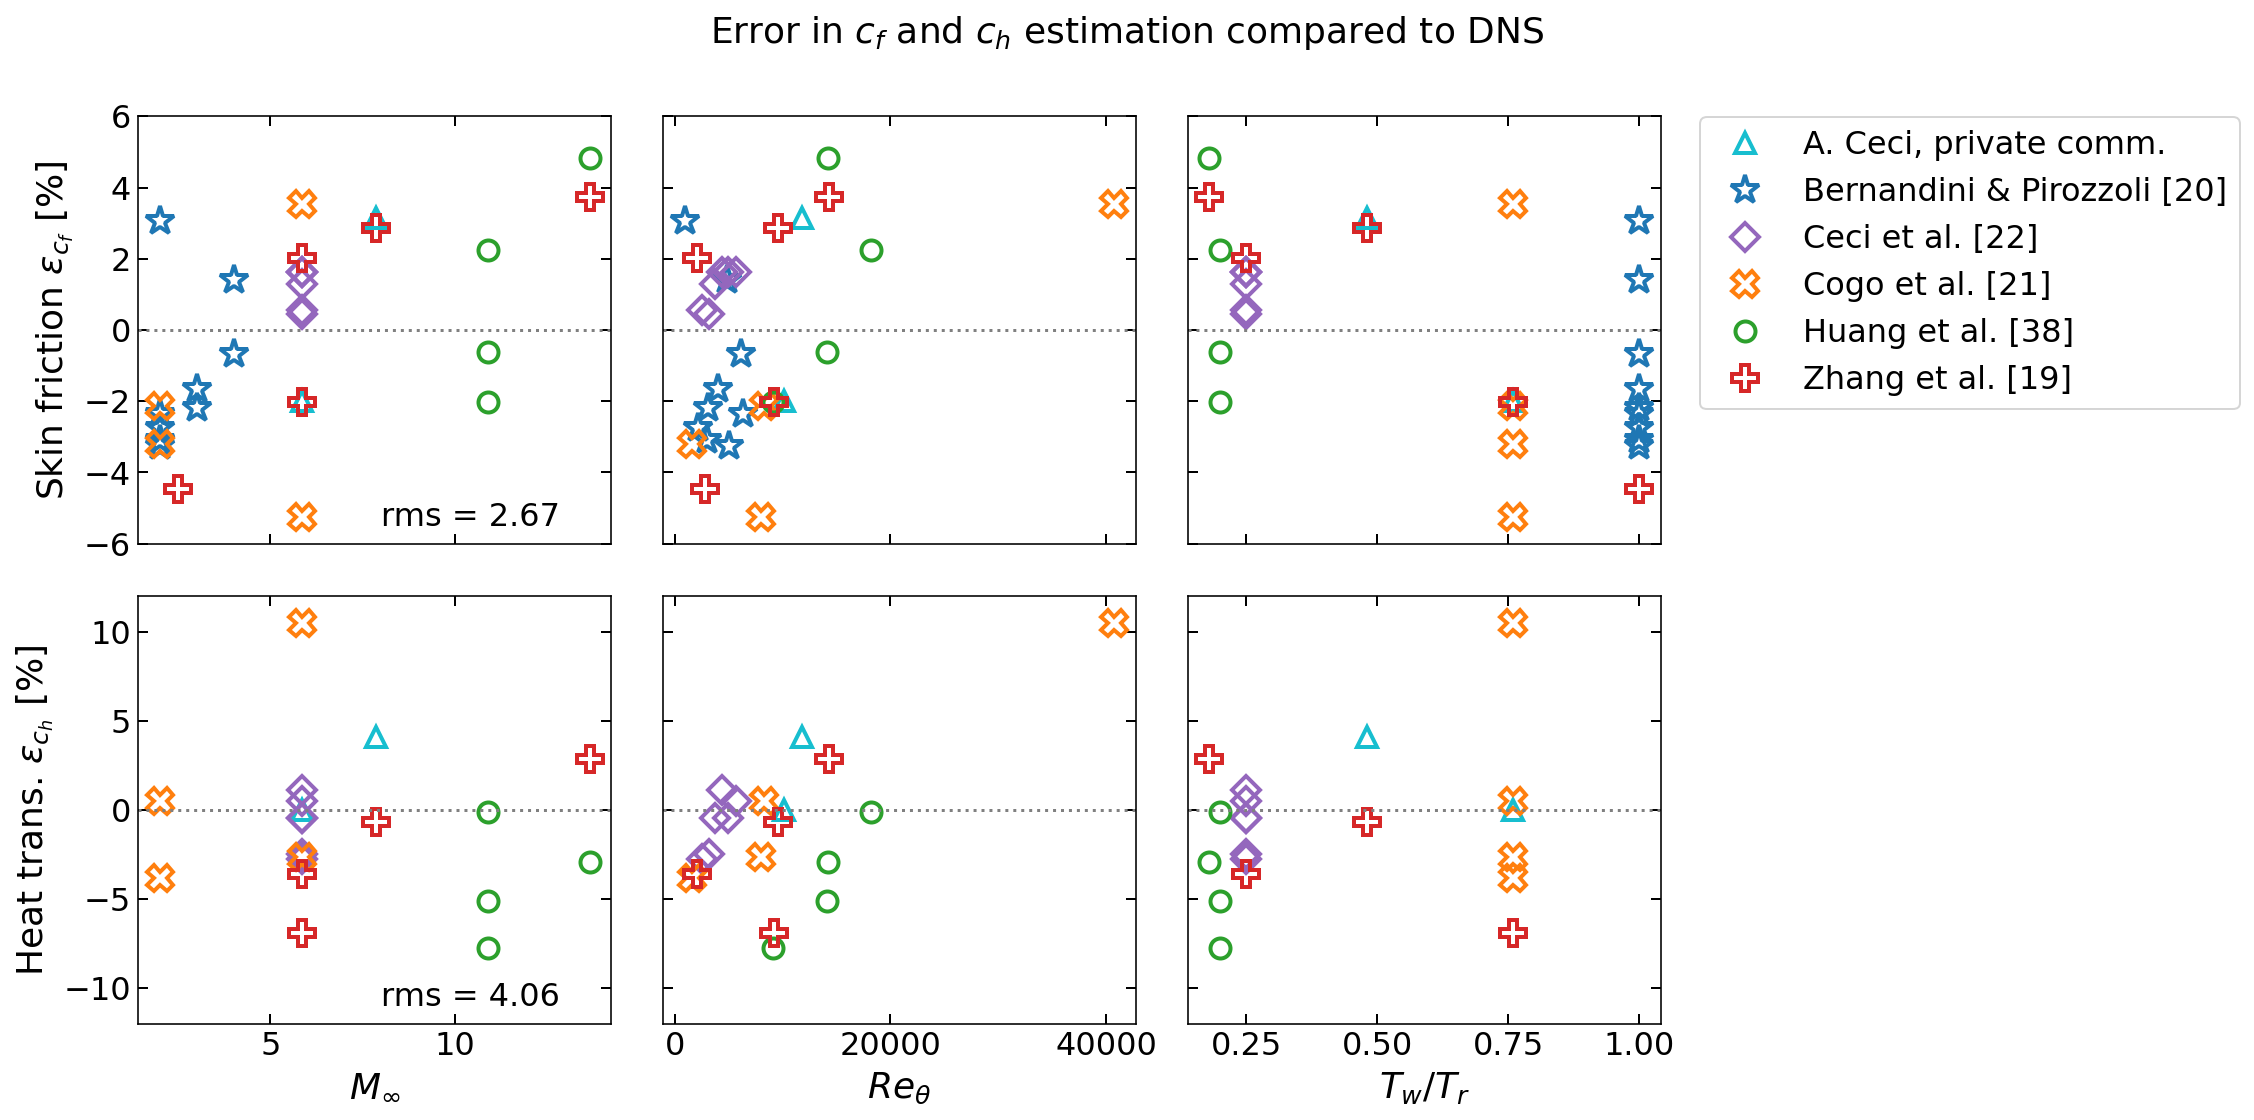

In [54]:
import pandas as pd
DNS = pd.read_csv("DataForDragAndHeatTransfer.csv")
groups = DNS.groupby('Author', as_index=True)

cf_rms = 0.0
ch_rms = 0.0

fig, ax = plt.subplots(2,3,figsize=(16,8), sharex='col', sharey='row')

for group_name, group in groups:
    for row_index, row in group.reset_index().iterrows():
        
        Minf      = row['Minf']
        ReTheta   = row['ReTheta']
        Tw_Tr     = row['Tw_Tr']
        viscLaw   = row['ViscLaw']
        Tinf_dim  = row['Tinf']
        cf_DNS    = row['cf_DNS']
        ch_DNS    = row['ch_DNS']

        label = None
        if row_index == 0:
            label = row['Author']

        cf,ch,_,_,_,_,_,_,_ = solver(ReTheta = ReTheta, Minf = Minf, Tw_Tr = Tw_Tr,
                                     viscLaw = viscLaw, Tinf_dim = Tinf_dim)

        cf_err  = (cf-cf_DNS)/cf_DNS*100
        ch_err  = (ch-ch_DNS)/ch_DNS*100
        
        cf_rms += cf_err**2
        ch_rms  = np.nansum([ch_rms,ch_err**2])

        params = {"marker": row['Symbol'], "color": row['Color'], "ms": 10*row['Size'], 
                  "mew": 2, "fillstyle": 'none', "linestyle": 'None', "label": label}
        
        ax[0,0].plot(Minf,    cf_err, **params)
        ax[0,1].plot(ReTheta, cf_err, **params)
        ax[0,2].plot(Tw_Tr,   cf_err, **params)
        
        ax[1,0].plot(Minf,    ch_err, **params)
        ax[1,1].plot(ReTheta, ch_err, **params)
        ax[1,2].plot(Tw_Tr,   ch_err, **params)

cf_rms = np.sqrt(cf_rms/DNS["cf_DNS"].count())
ch_rms = np.sqrt(ch_rms/DNS["ch_DNS"].count())

ax[0,0].text(8,-5.5, "rms = " + str(round(cf_rms,2)))
ax[1,0].text(8,-11,  "rms = " + str(round(ch_rms,2)))
ax[0,0].set_ylabel(r"Skin friction $\varepsilon_{c_f}~[\%]$",fontsize = 18)
ax[1,0].set_ylabel(r"Heat trans. $\varepsilon_{c_h}~[\%]$",fontsize = 18)
ax[1,0].set_xlabel(r"$M_\infty$",fontsize = 18)
ax[1,1].set_xlabel(r"$Re_\theta$",fontsize = 18)
ax[1,2].set_xlabel(r"$T_w/T_r$",fontsize = 18)

ax[0,0].set_ylim([-6, 6])
ax[1,0].set_ylim([-12, 12])

for a in ax.reshape(-1):
    a.tick_params(axis='both', which='both', direction='in',labelsize=16,right=True,top=True)
    a.tick_params(which='major', length=5, width=1)
    a.tick_params(which='minor', length=3, width=1)
    a.axhline(y=0, color="gray", linestyle=":")

ax[0,2].legend(bbox_to_anchor=(1.05, 1.035))

fig.suptitle(r"Error in $c_f$ and $c_h$ estimation compared to DNS", fontsize = 18)
plt.tight_layout()

## Plot estimated velocity and temperature profiles for these cases

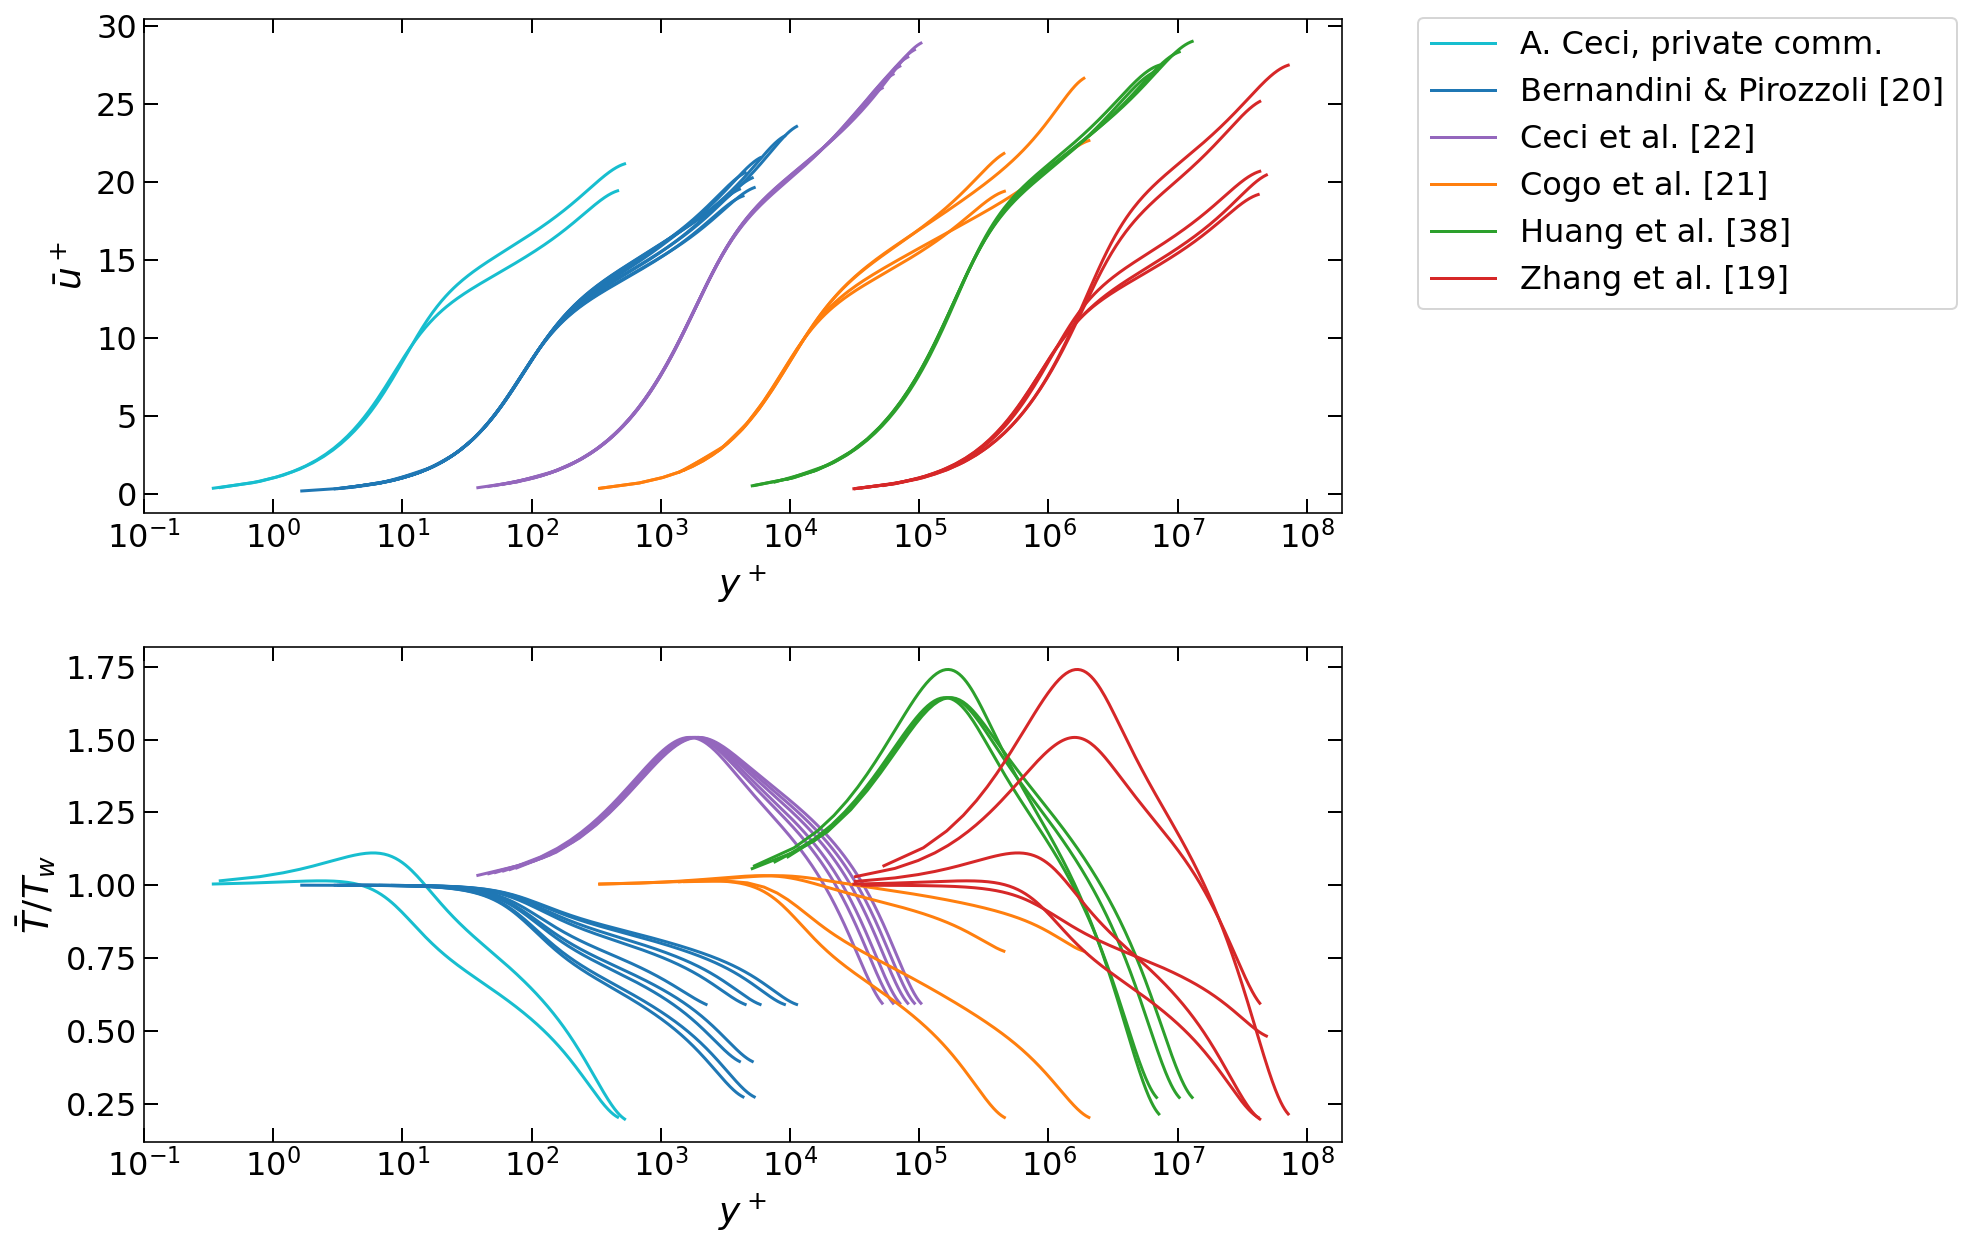

In [49]:
fig, ax = plt.subplots(2,1,figsize=(14,9))

mult_x = 0.1

for group_name, group in groups:
    for row_index, row in group.reset_index().iterrows():

        label = None
        if row_index == 0:
            label = row['Author']
            mult_x *= 10

        _,_,_,_,ypl, yst, upl, T_Tw,_ = solver(ReTheta  = row['ReTheta'], 
                                               Minf     = row['Minf'], 
                                               Tw_Tr    = row['Tw_Tr'],
                                               viscLaw  = row['ViscLaw'], 
                                               Tinf_dim = row['Tinf'])

        ax[0].semilogx(ypl[1:]*mult_x, upl[1:],  color = row['Color'], label=label)
        ax[1].semilogx(ypl[1:]*mult_x, T_Tw[1:], color = row['Color'], label=label)

ax[0].set_ylabel(r"$\bar u^+$",   fontsize = 18)
ax[1].set_ylabel(r"$\bar T/T_w$", fontsize = 18)

for a in ax:
    a.tick_params(axis='both', which='both', direction='in',labelsize=16,right=True,top=True)
    a.tick_params(which='major', length=7, width=1)
    a.tick_params(which='minor', length=4, width=1)
    a.set_xticks(10.0**np.arange(-1, 9, 1))
    a.set_xlabel(r"$y^+$",      fontsize = 18)

ax[0].legend(bbox_to_anchor=(1.05, 1.035))

plt.tight_layout()